#1. Introducing Ambari

* In the ambari dashboard:
  * The dashboard tab is an overview of what the cluster is doing.
    In the HDFS Disk usage you can edit it to show colors differently: (at 80% show orange and 95% show red), you can customize most of them.

NOTE: you could install everything Hadoop with ambari (Install pig, Tez, Hive, etc... Manually)

* In the services tab: 
  * Where you can go to any service (Hive, YARN, etc...)
  * Some of this services have subservices and customizations you can change.

* The Hosts tab:
  * Where you can see the actual host thats running.
  * You can select any host and see the history server for mapreduce.

* Alerts tab:
 * Allows you to set up automatic alerts that could e-mail you when something goes wrong.
 * Shows you any alerts Ambari considers relevent (eg, server is running our of space, the growth rate of data is growing too fast, etc...)

* Admin Tab:
  * Basically from here you can just see whats install and what versions there are + some security features.
  * Note: To use the Admin tab properly, you need to enable admin access to Ambari, for this you set up an admin user.
    + To do this:
    1. Open PuTTY
    2. Run `su root`
    3. Run `ambari-admin-password-reset` and that will prompt you to enter the password for the Ambari admin.
    4. Restart ambari.
    5. Login to ambari using admin instead of maria_dev.

* Grid icon:
  * Files view: 
    + This is  a view into the HDFS file system.
  * Hive View: 
    + You can do queries, upload data, etc...
  * Pig View:
    + Run pig scripts
    + Save Pig scripts, rerun them, etc...









#2. Introducing Pig

Pig basically lets you create MapReduce jobs without having to actually use MapReduce.

The language Pig uses is PigLatin, that is very similar to SQL, but the main difference is a procedural step by step language where we can set up different relations of your data using a very simple script format.
We can select data, filter it, go thorugh it line by line.



Where pig sits:

Note: pig could also run on TEZ, which usually helps you running everythig faster

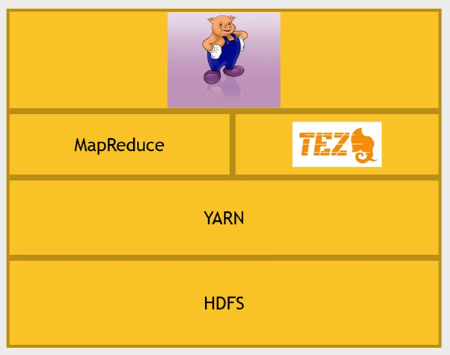

## Running Pig:

* You can use:
  + Grunt: A simple line-by-line (sort of command line) the Grunt prompt lets you type pig scripts one line at a time and execute them one line at a time.
    - Useful if you have a small dataset in which you want to do some quick experiments
  + Script: Simply give Pig a Script filename so you can save a Pig script to a file and run that from the command line using Pig.
  + Ambari: There is an ambari view for Pig that lets the user write and run and save and load Pig scripts right from the web browser (Dashboard)


#3. Example find the oldest movie with a 5-star rating using Pig
## Example
Find movies with an average rating of more than four stars and sort them by age

Loading the data

In [0]:
#This pig script is used to load the data itself.
ratings = LOAD '/user/maria_dev/ml-100k/u.data' AS  
  (userID:int, movieID:int, rating:int, ratingTime:int);


#This creates a relation named "ratings" with a given shcema:
  #it gives for example a bunch of lines (rows) like:
    # (660,229,2,891406212)  this is a tuple
    # userID, movieID, rating, age. All as ints
  
#This is the equivalent of a mapper in MapReduce

Use PigStorage if you need a different delimeter, for example with the metadata

In [0]:
metadata = LOAD '/user/maria_dev/ml-100k/u.item' USING
  PigStorage('|')AS (movieID:int, movieTitle:chararray,
                     releaseDate:chararray, videoRelease:chararray,
                     imdbLink:chararray);
  #The PigStorage part just gives it another delimeter
  #chararray is basically a string 

DUMP metadata; #This lets you dump all the contents of the entire relation 
  #NOTE: when dumping it would be preferable to be using a subset or data
    #So your PC does not get overwhelmed.
#Once you DUMP the metadata it gives you an output of lines(rows) containing a tuple

Creating a relation from another relation.

We need to transform that movie information to metadata into something that we can actually use... Since we want to sort by release date.



In [0]:
metadata = LOAD '/user/maria_dev/ml-100k/u.item' USING
  PigStorage('|')AS (movieID:int, movieTitle:chararray,
                     releaseDate:chararray, videoRelease:chararray,
                     imdbLink:chararray);

nameLookup = FOREACH metadata GENERATE movieID, movieTitle,
      ToUnixTime(ToDate(releaseDate, 'dd-MMM-yyyy')) AS releaseTime;
      #Basically we generate a new relation from an existing relation 
        #And we get a tuple with the data transformed.

Now we Group By (To figure out all the ratings associated with each individual movie), basically we get the average rating


In [0]:
ratingsByMovie = GROUP ratings BY movieID;
DUMP ratingsByMovie;

#This returns a new reduced relation where the movies are grouped with their ratings
  # you get a unique movieID, and all the other info becomes a list inside the Tuple
    # This is called a "bag"


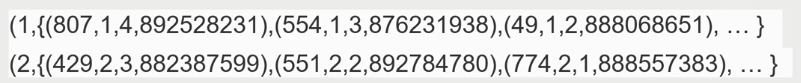

To compute the ratings:


In [0]:
avgRatings = FOREACH ratingsByMovie GENERATE group AS movieID,
  AVG(ratings.rating) AS avgRating;

#GENERATE means "generate new rows"
  # the group is the movieID (because thats what we grouped as in ratingsByMovie) 
  # the group name is an automatic name calling from PIG
    #and the average is called the avgRating

DUMP avgRatings;

# This returns (movieID, AverageRating)

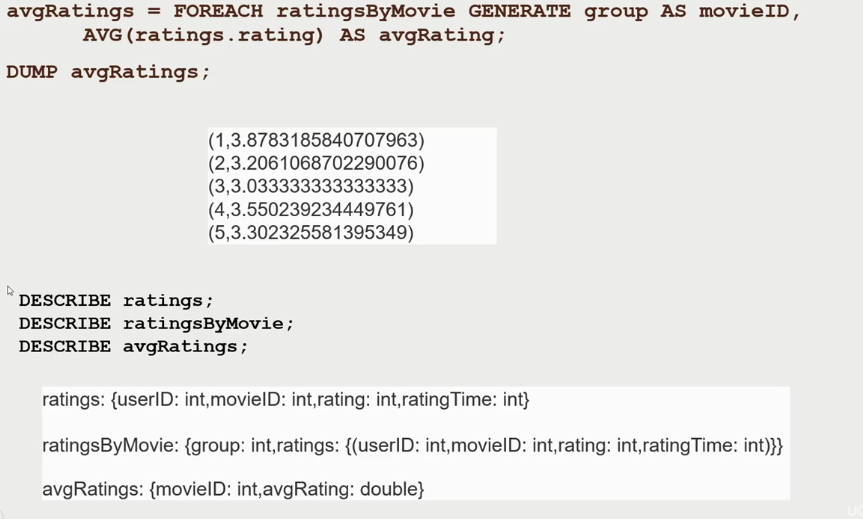

Now we filter things out (remove everything under 4 stars)

In [0]:
fiveStarMobies = FILTER avgRatings BY avgRating > 4.0;

Now we JOIN the movie names (because we filtered them out)

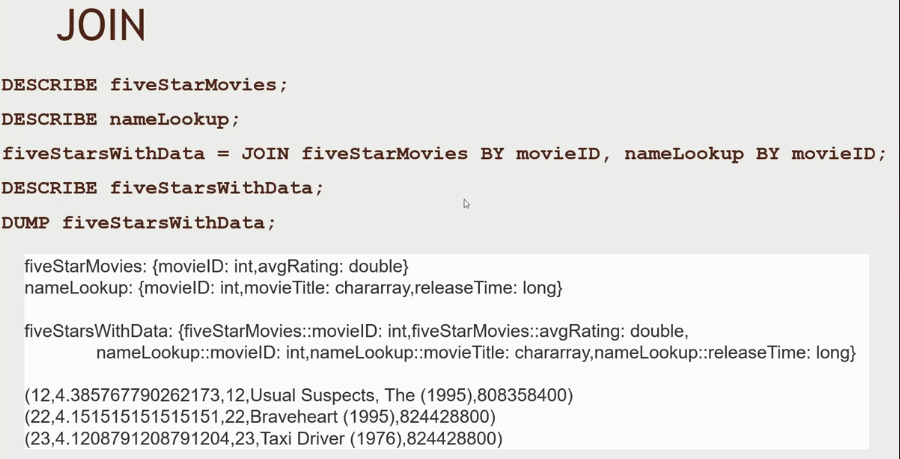

In [0]:
fiveStarsWithData = JOIN fiveStarMovies BY movieID, nameLookup BY movieID;
# Basically it says that you want to join the relations fiveStarMovies and nameLookup
# by the fields of movieID.
# You go through each row of fiveStarMovies, you look up the corresponding
  #row in nameLookup and joining that data in, to create a new relation
    #called fiveStars
  
  

Note, if you see the image, you can see that there are two movieID fields, that happens when you do a join, you get the database::name and the thing you joined (BY movieID) is what gets doubled.

You can clean this up if neccesary

We now order

In [0]:
oldestFiveStarMovies = ORDER fiveStarsWithData BY nameLookup::releaseTime;

# we basically order the data by releaseTime (release time is int EpochSeconds,
  # so it gets ordered well )
DUMP oldestFiveStarMovies

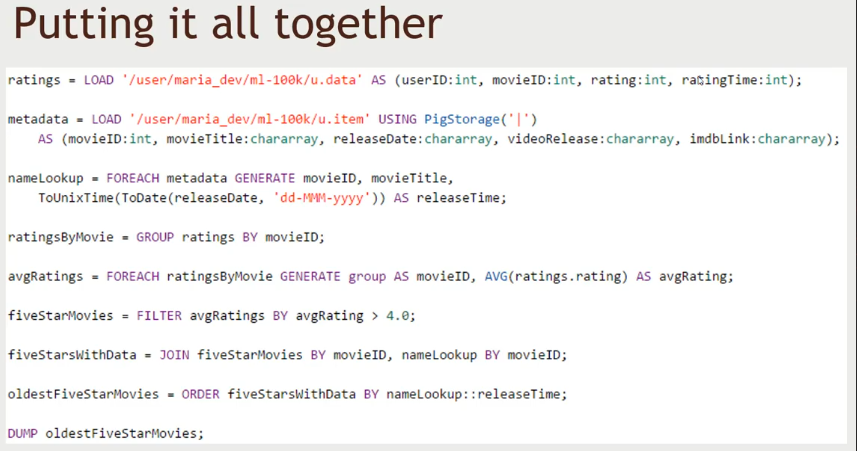

#4. Actually running the script in Hadoop

1. Open hadoop with ambari.
2. Upload the necessary files (into user/maria_dev/)
3. Go to view menu and go to Pig View
4. Go the the scripts tab and +New Script
5. type the script in the browser "notepad". And when you are finished click execute

##How to make this faster:

USE **TEZ** Instead of MapReduce

To do this we literally just click the checkmark of Execute on TEZ, and then execute.



#5. More Pig Latin, Pig Latin dictionary commands

Some more commands:
### Things you can do to a relation
* LOAD: Load up a bunch of data into a relation.
* STORE: Write things to disk
  - STORE ratings INTO 'outRatings' USING PigStorage(':');
* DUMP: just dumps things out into the console
  

* FILTER: Filtering things out in a relation based on some boolean expression.
* DISTINCT: gives back the unique values within a relation.
* FOREACH/GENERATE: Basically create a new relation from an existing one going through one line at a time and transorming it in some way.
* MAPREDUCE: Lets you call explicit mappers and reducers on a relation. 
* STREAM: Stream the results of Pig out to a process and just use standard in and standard out.
* SAMPLE: Create a random sample from your relation
  - NOTE: be careful when doing random samples with a JOIN because if you do random sample and try to join two relations togheter, there might be problems.

* JOIN:Join puts the resulting joined rows togheter into a tuple.
* COGROUP: Cogroup creates a separate tuple for each key and it creates this nested structure
* GROUP: Groups togheter all the different values associated with a given specified key.
* CROSS: Lets you do all the combinations between two relations (Also called the cartesian product), useful when you want to compare, but this can blow up quickly.
* CUBE: Its like CROSS but takes more than two columns and returns all the combinations.

* ORDER: Sort a relation that you have
* RANK: Its like order but it assigns a rank number to each row.
* LIMIT: Take back the first results from a relation (limit to the first 100 rows)
* UNION: Takes two relationships and merges them togheter
* SPLIT: Takes a relation and splits it up into more than one relation.

### Diagnostics:

* DESCRIBE: Prints out the schema of a given relation.
* EXPLAIN: Gives you a little insight of how Pig intends to execute a given query.
* ILLUSTRATE: Actually takes a sample from each relation and shows exactly what it is doing with each piece of data as you go.



### UDF's (User defined functions):
NOTE: This functions are built in java and require using .jar files etc...
* REGISTER: Basically says: "I have a jar file that contains my UDF's", please import it in.
* DEFINE: Assigns names to the funtions.
* IMPORT: Is used for importing macros for Pig file so you can actually have reusable bits of Pig code that you save office macros and you can import those macros into other pig scripts. 

### Some other functions and loaders:

* AVG: Get the average of items in a bag.
* CONCAT: Concatenate.
* COUNT: Count how many things are in the bag.
* MAX: get the maximum
* MIN: get the minimum value.
* SIZE: get size
* SUM: Add everything up.
* PigStorage: Uses field based data, defines delimeter.
* TextLoader: loads up one line of input/output data per row. (You get just a big blob of text)
* JsonLoader: Use the json format
* AvroStorage: This is a data format used in serialization and deserialization. This format is amenable to having a schema and also to being splittable across hadoop clusters.
* ParquetLoader: Another data format, it is column-oriented.
* OrcStorage: A popular compressed format.
* HBaseStorage: Integrate pig with HBase.

### NOTE: To learn more search for the O'REILLY books: Programming Pig and Hadoop the definitive guide

# 6. Find the most-rated one-star movie

* Find all movies with an average rating less than 2.0

* Sort them by the total number of ratings

HINT:
We have basically just done this but you need to use COUNT() to get the count the number of items in a bag.

In [0]:
ratings = LOAD '/user/maria_dev/ml-100k/u.data' AS (userID:int, movieID:int, rating:int, ratingTime:int);

metadata = LOAD '/user/maria_dev/ml-100k/u.item' USING PigStorage('|')
	AS (movieID:int, movieTitle:chararray, releaseDate:chararray, videoRealese:chararray, imdblink:chararray);
   
nameLookup = FOREACH metadata GENERATE movieID, movieTitle,
	ToUnixTime(ToDate(releaseDate, 'dd-MMM-yyyy')) AS releaseTime;
   
ratingsByMovie = GROUP ratings BY movieID;

avgRatings = FOREACH ratingsByMovie GENERATE group as movieID, AVG(ratings.rating) as avgRating, COUNT(ratings.rating) as timesRated;

fiveStarMovies = FILTER avgRatings BY avgRating < 2.0;

fiveStarsWithData = JOIN fiveStarMovies BY movieID, nameLookup BY movieID;

oldestFiveStarMovies = ORDER fiveStarsWithData BY nameLookup::timesRated;

DUMP oldestFiveStarMovies;


Prof solution
NOTE: The main difference between his solution and mine is that i just ordered the namedBadMovies array, he on the other hand created a new array.

In [0]:
ratings = LOAD '/user/maria_dev/ml-100k/u.data' AS (userID:int, movieID:int, rating:int, ratingTime:int);

metadata = LOAD '/user/maria_dev/ml-100k/u.item' USING PigStorage('|')
	AS (movieID:int, movieTitle:chararray, releaseDate:chararray, videoRealese:chararray, imdblink:chararray);
   
nameLookup = FOREACH metadata GENERATE movieID, movieTitle; #Quito lo de UNIXTIME
   
ratingsByMovie = GROUP ratings BY movieID;

avgRatings = FOREACH ratingsByMovie GENERATE group as movieID, AVG(ratings.rating) as avgRating, COUNT(ratings.rating) as numRatings;

badMovies = FILTER avgRatings BY avgRating < 2.0; #changed the name of the variable

namedBadMovies = JOIN badMovies BY movieID, nameLookup BY movieID; #changed names

finalResults = FOREACH namedBadMovies GENERATE nameLookup::movieTitle AS movieName,
  badMovies::avgRating AS avgRating, badMovies::numRatings AS numRatings;

finalResultsSorted = ORDER finalResults BY numRatings DESC;

DUMP finalResultsSorted;



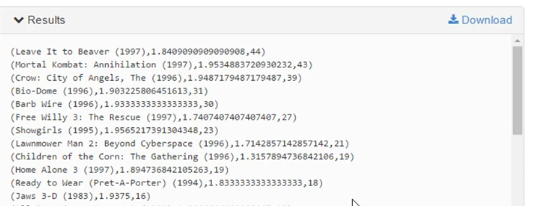